# Importar Librerias

In [75]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

import sys
import os
main_dir = os.path.abspath('..')
export_path = os.path.join(main_dir,'00_Utilities')
# adding Folder_2 to the system path
sys.path.insert(0, export_path)
from dirFunc import *

# Importar Datos

In [76]:
ruta_origen = 'Datos'

# De SAP
fRepuestos = pd.read_csv(ruta_origen + '\\fRepuestos.csv')
fHh = pd.read_csv(ruta_origen + '\\fHh.csv')
fOperaciones = pd.read_csv(ruta_origen + '\\fOperaciones.csv')
fWip = pd.read_csv(ruta_origen + '\\fWip.csv')

# De Qplus
aQplus = pd.read_csv(ruta_origen + '\\aQplus.csv')
fQplus = pd.read_csv(ruta_origen + '\\fQplus.csv',index_col='OSMadre')

# De Trabajadores
fTrabajadores = pd.read_csv(ruta_origen + '\\fTrabajadores.csv',index_col='NPersonal')

# De Cursos
hCursos = pd.read_csv(ruta_origen + '\\hCursos.csv')
hCursosAll = pd.read_csv(ruta_origen + '\\hCursosAll.csv')
fHistorial = pd.read_csv(ruta_origen + '\\fHistorial.csv')

In [77]:
with open('Datos/kitsComponente.pkl', 'rb') as handle:
    kitsComponentes = pickle.load(handle)

# Creacion Dataframe principal

In [78]:
df = fQplus.copy()
df = df.drop(columns=['NParte','serieComp','serieEquipo','tipoOrden','fechaLlegada','fechaPrometida','fechaTermino'])
df.columns=['genTipoComp','genModelo','genEstado','genTipoReparacion','genHh']

# Creacion de Variables

## Generales

### genTipoComp

In [79]:
df['genModelo'] = df['genModelo'].replace('777G WTR','777G').replace('777F/WT','777F').replace('777GQ WTR','777G')

In [80]:
tolerance = 0.03

# Agrupando modelos con poca frecuencia
for comp in df.genTipoComp.unique():
    col = df[df['genTipoComp'] == comp].genModelo
    series = pd.value_counts(col)
    mask = (series/series.sum()).lt(tolerance)
    values = np.where(col.isin(series[mask].index), "Otros modelos de " + comp, col)
    df.loc[df.genTipoComp==comp,'genModelo'] = values

In [81]:
df[df.genTipoComp=='CO'].genModelo.value_counts()

797B                   60
797F                   39
Otros modelos de CO    15
793F                    7
793C                    4
793D                    4
Name: genModelo, dtype: int64

In [82]:
# print('COMPLETO')
# for i in ['CO','DI','MA','MF','MO','TR']:
#     media = df[df['genTipoComp']==i].genYCostos.mean()
#     print(i+": " + str(round(media,2)))
# print("Completo: " + str(round(df.genYCostos.mean(),2)))
# print('MANO DE OBRA')
# for i in ['CO','DI','MA','MF','MO','TR']:
#     media = df[df['genTipoComp']==i].moYCostos.mean()
#     print(i+": " + str(round(media,2)))
# print("Completo: " + str(round(df.moYCostos.mean(),2)))
# for i in ['CO','DI','MA','MF','MO','TR']:
#     media = df[df['genTipoComp']==i].repYCostos.mean()
#     print(i+": " + str(round(media,2)))
# print("Completo: " + str(round(df.repYCostos.mean(),2)))
# print('REPUESTOS')

### genNVueltas

In [83]:
def getNVueltas(row, dataframe):
    limiteFecha = (dataframe.fechaTermino < row['fechaTermino'])
    filtroSerieComponente = (dataframe.serieComp == row['serieComp'])
    cantidadRepeticionesComponente = len(dataframe[limiteFecha & filtroSerieComponente])
    return cantidadRepeticionesComponente

In [84]:
df['genNVueltas'] = fQplus.apply(lambda x: getNVueltas(x,aQplus),axis=1)

### genDuracion

In [85]:
def replaceConditionalMean(df, condition_cols, cols):
    means = df.groupby(condition_cols)[cols].transform('mean')
    return df.fillna(means.to_dict('series'))

In [86]:
filterDur = fQplus[(~((fQplus.fechaLlegada.isna()) | (fQplus.fechaTermino.isna())))]
filterDur['fechaTermino'] = pd.to_datetime(filterDur.fechaTermino)
filterDur['fechaLlegada'] = pd.to_datetime(filterDur.fechaLlegada)
df['genDuracion'] = (filterDur.fechaTermino - filterDur.fechaLlegada).dt.days
# df['genDuracion'] = replaceConditionalMean(df,['genTipoComp'],['genDuracion'])['genDuracion']

c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### genDemora

In [87]:
filterDur = fQplus[(~(fQplus.fechaPrometida.isna()) | (fQplus.fechaTermino.isna()))]
filterDur['fechaTermino'] = pd.to_datetime(filterDur.fechaTermino)
filterDur['fechaPrometida'] = pd.to_datetime(filterDur.fechaPrometida)
df['genDemora'] = (filterDur.fechaTermino - filterDur.fechaPrometida).dt.days
# df['genDemora'] = replaceConditionalMean(df,['genTipoComp'],['genDemora'])['genDemora']

c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Repuestos

### Preparacion

In [88]:
# Crear lista kits

from itertools import chain
kits = list(chain(*kitsComponentes.values()))
listaKits = list(dict.fromkeys([kit.split('.')[0].replace('-','') for kit in kits]))

In [89]:
# Definir repuestos kits

vRepuestos = fRepuestos.copy()
repProcesados = vRepuestos["Material"].str.split('.').str[0]
# True si kit, else false
vRepuestos['KIT'] = np.where(repProcesados.isin(listaKits), True, False) 

In [90]:
# Columnas descritoras del origen de los repuestos
vRepuestos['repMS'] = vRepuestos.Material.str.endswith('.444') # Duda: No se deben contar los D.444?
vRepuestos['repExterno'] = (((vRepuestos.Material.str[1]=='R') | (vRepuestos.Material.str[2]=='R')) & (~vRepuestos.repMS))

### Utilidades

In [91]:
# Para obtener las cantidades y costos de los repuestos segun si son kits por orden de servicio
def getRepInfoKit(df,repDf, tipo=None,kit=None, nombreOSMadre='OSMadre',col = 'Material'):
    name = 'rep'
  
    if tipo == 'Externo':
        filter=(repDf.repExterno)
    elif tipo == 'MS':
        filter=(repDf.repMS)
    elif tipo == 'Nuevo':
        filter=(~repDf.repMS) & (~repDf.repExterno)
    else:
        filter = np.ones((len(repDf),), dtype=bool)
        tipo=''

    if kit is not None:
        if tipo!='MS':
            filter = (repDf.KIT) & (filter) if kit else (~repDf.KIT) & (filter)
            name+= 'Kit' if kit else 'NoKit'
        else:
            return

    grouper = repDf[filter].groupby([nombreOSMadre])[col]
    
    if col=='Cantidad':
        name += "Cant"
        calculation = grouper.sum()
    elif col=='Costo':
        name += "Cost"
        calculation = grouper.sum()
    elif col=='Material':
        name += "NP"
        calculation = grouper.nunique()
    name += tipo
    
    df[name] = calculation
    # df[name].fillna(0,inplace=True)

### Cantidades y numero de partes de los repuestos

In [92]:
# Calculo de Numero de Partes
for col in ['Material','Cantidad']:
    for kit in [None, True, False]:
        for tipo in [None,'Nuevo','Externo','MS']:
            getRepInfoKit(df,vRepuestos, tipo=tipo,kit=kit, col=col)
# Opcional, añade columnas de costos
# for col in ['Costo']:
#     for kit in [None, True, False]:
#         for tipo in [None,'Nuevo','Externo']:
#             getRepInfoKit(df,vRepuestos, tipo=tipo,kit=kit, col=col)

## Mano de Obra

### Utilidades

Variacion Positiva: HH Real menor al cotizado (ahorro)

Variacion Nevativa: HH Real mayor al cotizado (perdida)

In [93]:
def calcTrabajo(df,dfOper,tipo=None,operacion = None):
    # Aplica el filtro deseado para clasificar entre las tres operaciones
    if operacion=='Desarme':
        criterio = 'DESARMAR|EVALUAR|DESARME|EVALUACION'
        filtro = dfOper[dfOper.Descripcion.str.contains(criterio,case = False)]
    elif operacion == 'Salvataje':
        criterio = '(END)|END | END|END,'
        filtro = dfOper[dfOper.Descripcion.str.contains(criterio,case = False)]
    elif operacion == 'Armado':
        criterio = 'DESARMAR|EVALUAR|DESARME|EVALUACION|(END)|END | END|END,'
        filtro = dfOper[~dfOper.Descripcion.str.contains(criterio,case = False)]  
    else:
        filtro = dfOper
        operacion = ''
        
    if tipo =='Trabajo':
        # Calcula el total del trabajo realizado por orden de servicio
        trabajo = filtro.groupby(['OSMadre'])['TrabajoCotizado','TrabajoReal'].sum()
        # Si no se posee registro de trabajo real, se usa el cotizado
        trabajo.TrabajoReal[trabajo.TrabajoReal==0] = trabajo.TrabajoCotizado[trabajo.TrabajoReal==0]

        # Calculo de la Variacion
        trabajo['Variacion'] = (trabajo['TrabajoCotizado'] - trabajo['TrabajoReal'])/trabajo['TrabajoReal']
        # Corregir casos en que no se cuenta con un trabajo cotizado
        trabajo.Variacion[trabajo.TrabajoCotizado==0] = 0
        trabajo.drop(columns=['TrabajoCotizado'],inplace=True)

        # Adding to df
        df['mo' + operacion + 'TrabajoReal'] = trabajo['TrabajoReal']
        # df['mo' + operacion + 'TrabajoReal'].fillna(0, inplace=True)
        df['mo' + operacion + 'Variacion'] = trabajo['Variacion']
        # df['mo' + operacion + 'Variacion'].fillna(0, inplace=True)
    elif tipo == 'Personal':
        filtro = filtro.set_index(['Orden','Operacion'])
        trabajoPersonal = fHh.groupby(['Orden','Operacion'])['TrabajoReal'].sum()
        cantPersonal = fHh.groupby(['Orden','Operacion'])['NPersonal'].nunique()
        filtro['TrabPersonal'] = trabajoPersonal
        filtro['TrabPersonal'].fillna(0,inplace=True)
        filtro['CantPersonal'] = cantPersonal
        filtro['CantPersonal'].fillna(0,inplace=True)
        df['mo' + operacion + 'TrabPersonal'] = filtro.groupby(['OSMadre'])['TrabPersonal'].sum()
        # df['mo' + operacion + 'TrabPersonal'].fillna(0, inplace=True)
        df['mo' + operacion + 'CantPersonal'] = filtro.groupby(['OSMadre'])['CantPersonal'].sum()
        # df['mo' + operacion + 'CantPersonal'].fillna(0, inplace=True)
    return filtro


### Trabajo Real / Variacion

In [94]:
# Calculo de Trabajo y varianza por operaciones de las Ordenes de Servicio
temp = calcTrabajo(df,fOperaciones,tipo='Trabajo',operacion=None)
tempDesarme = calcTrabajo(df,fOperaciones,tipo='Trabajo',operacion='Desarme')
calcTrabajo(df,fOperaciones,tipo='Trabajo',operacion='Salvataje')
calcTrabajo(df,fOperaciones,tipo='Trabajo',operacion='Armado')

c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


,serieComp,Orden,Operacion,Descripcion,serieEquipo,TrabajoCotizado,TrabajoReal,OSMadre
0,JSM00421,505900149207,530,tta maestranza - garantia,10039907,4773.0,0.0,505900149200
1,JSM00421,505900149207,550,MUESTRA DE ACEITE X 06,10039907,196.0,0.0,505900149200
3,JSM00134,505900479001,40,SOLPED MSHOP OS/496801 RECUP HOUSING,10039831,0.0,2.0,505900479000
4,JSM00188,505900896001,520,GRANALLADO CARTER (ZAHIR) OS 50590089600,10039853,0.0,10.5,505900896000
5,JSM00173,505900913101,540,GRANALLADO CARTER (ZAHIR)OS 505900913101,10039840,0.0,3.0,505900913100
...,...,...,...,...,...,...,...,...
21992,LAJ00173,505901353702,140,ACOPLE SUSPENSION MAZA,10040579,8.0,8.0,505901353700
21993,LAJ00173,505901353702,150,PINTAR,10040579,2.0,0.0,505901353700
21994,LAJ00173,505901353702,160,MONTAJE BASE NORMAL PLANA,10040579,3.0,3.0,505901353700
21995,LAJ00173,505901353702,170,INSUMOS REPARACION DE COMPONENTE,10040579,7.7,0.0,505901353700


In [95]:
tempDesarme

,serieComp,Orden,Operacion,Descripcion,serieEquipo,TrabajoCotizado,TrabajoReal,OSMadre
35,LAJ00175,505900078901,20,DESARMAR MOTOR,10040581,80.0,89.5,505900078900
36,LAJ00175,505900078901,30,DESARMAR MECANISMO DE VALVULAS,10040581,18.0,19.0,505900078900
37,LAJ00175,505900078901,40,DESARMAR BANCO DE CULATAS,10040581,36.0,41.5,505900078900
38,LAJ00175,505900078901,50,DESARMAR CULATA ARMADA (TODO INCL),10040581,38.0,42.0,505900078900
39,LAJ00175,505900078901,60,DESARMAR GRUPO CAMISA/PISTON/BIELA,10040581,31.0,31.0,505900078900
...,...,...,...,...,...,...,...,...
21966,JSM00425,505901353401,30,DESARMAR Y EVALUAR CAJA,10039909,14.0,20.5,505901353400
21967,JSM00425,505901353401,40,DESARMAR Y EVALUAR BOMBA HIDRAULICA,10039909,14.0,14.0,505901353400
21977,LAJ00173,505901353701,10,DESARMAR Y EVALUAR SUSPENSION,10040579,12.0,13.0,505901353700
21982,LAJ00173,505901353702,40,DESARME Y EVALUACION WHEEL,10040579,15.0,15.0,505901353700


### Trabajo y personal de mano de obra

In [96]:
# Calculo del Total de personal y el trabajo de la mano de obra de las Ordenes de Servicio
calcTrabajo(df,fOperaciones,tipo='Personal',operacion=None)
calcTrabajo(df,fOperaciones,tipo='Personal',operacion='Desarme')
calcTrabajo(df,fOperaciones,tipo='Personal',operacion='Salvataje')
calcTrabajo(df,fOperaciones,tipo='Personal',operacion='Armado')

c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


serieComp                               Descripcion  \
Orden        Operacion                                                       
505900149207 530        JSM00421                 tta maestranza - garantia   
             550        JSM00421                    MUESTRA DE ACEITE X 06   
505900479001 40         JSM00134      SOLPED MSHOP OS/496801 RECUP HOUSING   
505900896001 520        JSM00188  GRANALLADO CARTER (ZAHIR) OS 50590089600   
505900913101 540        JSM00173  GRANALLADO CARTER (ZAHIR)OS 505900913101   
...                          ...                                       ...   
505901353702 140        LAJ00173                    ACOPLE SUSPENSION MAZA   
             150        LAJ00173                                    PINTAR   
             160        LAJ00173                 MONTAJE BASE NORMAL PLANA   
             170        LAJ00173          INSUMOS REPARACION DE COMPONENTE   
             180        LAJ00173                      PROTECCIONES DE STUD   

                        serieEquipo  TrabajoCotizado  TrabajoReal  \
Orden        Operacion                                              
505900149207 530           10039907           4773.0          0.0   
             550           10039907            196.0          0.0   
505900479001 40            10039831              0.0          2.0   
505900896001 520           10039853              0.0         10.5   
505900913101 540           10039840              0.0          3.0   
...                             ...              ...          ...   
505901353702 140           10040579              8.0          8.0   
             150           10040579              2.0          0.0   
             160           10040579              3.0          3.0   
             170           10040579              7.7          0.0   
             180           10040579              1.9          0.0   

                             OSMadre  TrabPersonal  CantPersonal  
Orden        Operacion                                            
505900149207 530        505900149200           0.0           0.0  
             550        505900149200           0.0           0.0  
505900479001 40         505900479000           2.0           1.0  
505900896001 520        505900896000           0.0           0.0  
505900913101 540        505900913100           0.0           0.0  
...                              ...           ...           ...  
505901353702 140        505901353700           8.0           1.0  
             150        505901353700           0.0           0.0  
             160        505901353700           3.0           1.0  
             170        505901353700           0.0           0.0  
             180        505901353700           0.0           0.0  

[15868 rows x 8 columns]

### Ponderador de Experiencia en empresa

In [97]:
# Crea las agrupaciones entre OSMadre y NPersonal, y suma el trabajo realizado
trabPers = fHh.copy()
trabPers = trabPers.groupby(['OSMadre','NPersonal'])['TrabajoReal'].sum()

# Agrega la fecha en que empieza la os y la fecha de admision del trabajador
trabPers = trabPers.reset_index().set_index(['OSMadre'])
trabPers['fechaLlegada'] = fQplus.fechaLlegada
trabPers = trabPers.reset_index().set_index(['NPersonal'])
trabPers['fechaIngreso'] = fTrabajadores.fechaIngreso

trabPers.reset_index(inplace=True)
# Cambia el tipo de dato de las fechas a fechas
trabPers['fechaIngreso'] = pd.to_datetime(trabPers.fechaIngreso)
trabPers['fechaLlegada'] = pd.to_datetime(trabPers.fechaLlegada)

# Filtrando columnas con nan
filterExp = trabPers[(~((trabPers.fechaLlegada.isna()) & (trabPers.fechaIngreso.isna())))]

# Columna fechaIngreso no tiene nan

# Agregar fecha termino
filterExp = filterExp.set_index('OSMadre')
filterExp['fechaTermino'] = fQplus.fechaTermino
filterExp.reset_index(inplace=True)

# Calcular Experiencia
filterExp['fechaTermino'] = pd.to_datetime(filterExp.fechaTermino)
filterExp['experiencia'] = (filterExp.fechaTermino - filterExp.fechaIngreso).dt.days

# calcular porcentajes relativos
filterExp['porcTrab'] =(filterExp['TrabajoReal'] / filterExp.groupby('OSMadre')['TrabajoReal'].transform('sum'))
# filterExp['porcExp'] =(filterExp.experiencia / filterExp.groupby('OSMadre')['experiencia'].transform('mean'))

# filterExp['pondExp'] = filterExp['porcTrab'] * filterExp['porcExp']
filterExp['pondExp'] = filterExp['porcTrab'] * filterExp['experiencia']

# Agregar ponderador a dataframe
df['genPondExp'] = filterExp.groupby(['OSMadre'])['pondExp'].sum()

2773.9565217391305
2433.7262996941895


<AxesSubplot:>

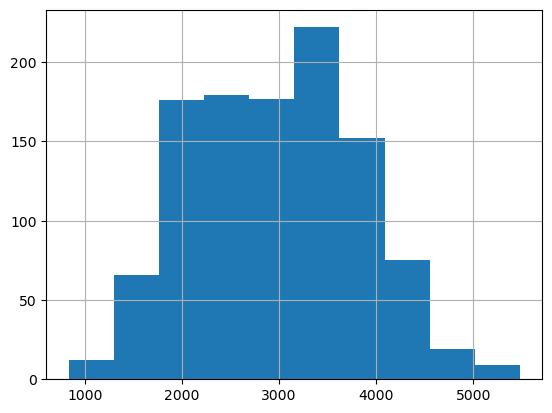

In [98]:
print(filterExp[filterExp.OSMadre == 505900078900].experiencia.mean())
print(filterExp[filterExp.OSMadre == 505900078900].pondExp.sum())

filterExp.groupby(['OSMadre'])['experiencia'].mean().hist()

In [99]:
trabPers

,NPersonal,OSMadre,TrabajoReal,fechaLlegada,fechaIngreso
0,3475668,505900078900,4.5,2018-11-27,2018-03-05
1,3477871,505900078900,67.0,2018-11-27,2018-06-01
2,3477879,505900078900,10.5,2018-11-27,2018-06-01
3,3477881,505900078900,44.5,2018-11-27,2018-06-01
4,3478171,505900078900,2.0,2018-11-27,2018-07-03
...,...,...,...,...,...
13395,3484014,508600122400,15.0,2020-03-27,2017-05-02
13396,3477933,508600122500,2.0,2020-03-27,2018-06-08
13397,3482721,508600122500,46.5,2020-03-27,2017-04-20
13398,3484014,508600122500,0.5,2020-03-27,2017-05-02


### Ponderado Nivel de trabajadores

In [100]:
# Variables con la informacion de los niveles de los trabajadores de operacion
niveles = {'M1':"1",'M2':'2','M3':'3','T1':'4','T2':'5','T3':'6','TS':'7'}
fTrabajadores['numNivel'] = fTrabajadores.Nivel.replace(to_replace = niveles.keys(), value = niveles.values())

In [101]:
# Filtrar unicamente por los trabajadores operarios
hhPersonal = fHh.copy()


# Filtro de desarme
filterDesarme = tempDesarme.Orden.astype(str) + tempDesarme.Operacion.astype(str)

operInDesarme = (hhPersonal.Orden.astype(str) + hhPersonal.Operacion.astype(str))

hhPersonal = hhPersonal[operInDesarme.isin(filterDesarme)]

# obtener total de trabajo realizado por un operario
hhPersonal = hhPersonal.groupby(['OSMadre','NPersonal'])['TrabajoReal'].sum().reset_index()
hhPersonal.set_index(['NPersonal'],inplace=True)

hhPersonal['Nivel'] = fTrabajadores.numNivel
hhPersonal.reset_index(inplace=True)

hhPersonal['Nivel'] = pd.to_numeric(hhPersonal['Nivel'], errors='coerce')

# calcular porcentajes relativos
hhPersonal['porcTrab'] =(hhPersonal['TrabajoReal'] / hhPersonal.groupby('OSMadre')['TrabajoReal'].transform('sum'))
# calcular ponderador
hhPersonal['pondNivel'] = hhPersonal['porcTrab'] * hhPersonal['Nivel']

pondNivel = hhPersonal.groupby(['OSMadre'])['pondNivel'].sum().reset_index()

pondNivel.set_index('OSMadre', inplace=True)
# Guardando ponderador en df principal

df['genPondNivel'] = pondNivel.pondNivel

3.1
2.8646153846153846


<AxesSubplot:>

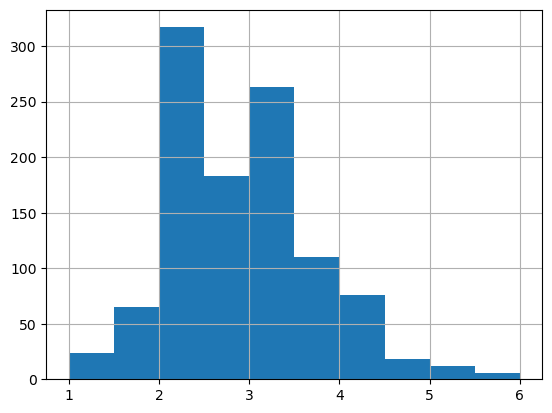

In [102]:
print(hhPersonal[hhPersonal.OSMadre == 505900078900].Nivel.mean())
print(hhPersonal[hhPersonal.OSMadre == 505900078900].pondNivel.sum())

hhPersonal.groupby(['OSMadre'])['Nivel'].mean().hist()

<AxesSubplot:>

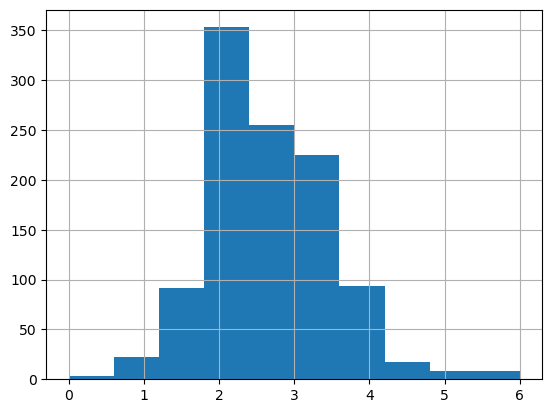

In [103]:
df.genPondNivel.hist()

## TTA

In [104]:
df[[i for i in df.columns if i.startswith('rep')]]

,repNP,repNPNuevo,repNPExterno,repNPMS,repKitNP,repKitNPNuevo,repKitNPExterno,repNoKitNP,repNoKitNPNuevo,repNoKitNPExterno,repCant,repCantNuevo,repCantExterno,repCantMS,repKitCant,repKitCantNuevo,repKitCantExterno,repNoKitCant,repNoKitCantNuevo,repNoKitCantExterno
OSMadre,,,,,,,,,,,,,,,,,,,,
505900078900,748.0,731.0,17.0,NaN,366.0,362.0,4.0,382.0,369.0,13.0,6242.0,6236.0,6.0,NaN,3799.0,3797.0,2.0,2443.0,2439.0,4.0
505900080900,664.0,648.0,16.0,NaN,347.0,342.0,5.0,317.0,306.0,11.0,5667.0,5656.0,11.0,NaN,4084.0,4079.0,5.0,1583.0,1577.0,6.0
505900088700,1157.0,1129.0,28.0,NaN,426.0,420.0,6.0,731.0,709.0,22.0,14809.0,14743.0,66.0,NaN,7963.0,7933.0,30.0,6846.0,6810.0,36.0
505900111400,624.0,606.0,18.0,NaN,375.0,372.0,3.0,249.0,234.0,15.0,7493.0,7479.0,14.0,NaN,6081.0,6079.0,2.0,1412.0,1400.0,12.0
505900127200,807.0,789.0,18.0,NaN,403.0,400.0,3.0,404.0,389.0,15.0,9352.0,9330.0,22.0,NaN,7239.0,7229.0,10.0,2113.0,2101.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505901343300,25.0,17.0,NaN,8.0,5.0,5.0,NaN,20.0,12.0,NaN,30.0,30.0,NaN,0.0,9.0,9.0,NaN,21.0,21.0,NaN
505901346600,35.0,25.0,NaN,10.0,10.0,10.0,NaN,25.0,15.0,NaN,60.0,60.0,NaN,0.0,36.0,36.0,NaN,24.0,24.0,NaN
505901349800,17.0,15.0,NaN,2.0,4.0,4.0,NaN,13.0,11.0,NaN,60.0,60.0,NaN,0.0,42.0,42.0,NaN,18.0,18.0,NaN


## Cursos

In [105]:
fCompletados = fHistorial.copy()
fCompletados['IDCurso'] = fCompletados['IDCurso'].astype(str)
# fCompletados = fCompletados[((fCompletados.calificacion == 'Apto'))]
fCompletados = fCompletados.groupby(['NPersonal','IDCurso']).size().reset_index()
totalCursos = hCursos.IDCurso.tolist()
fCompletados = fCompletados[fCompletados.IDCurso.isin(totalCursos)]
fCompletados = fCompletados.NPersonal.value_counts().reset_index()
fCompletados.columns = ['NPersonal','completados']
fCompletados['avance'] = fCompletados.completados / len(totalCursos)
fCompletados.set_index(['NPersonal'],inplace=True)

In [106]:
hhCurso = fHh.copy()

# Filtro de Operaciones para obtener solo aquellas que se relacionan con desarme y evaluación
filterDesarme = tempDesarme.Orden.astype(str) + tempDesarme.Operacion.astype(str)

operInDesarme = (hhCurso.Orden.astype(str) + hhCurso.Operacion.astype(str))

hhCurso = hhCurso[operInDesarme.isin(filterDesarme)]

# obtener total de trabajo realizado por un operario
hhCurso = hhCurso.groupby(['OSMadre','NPersonal'])['TrabajoReal'].sum().reset_index()
hhCurso.set_index(['NPersonal'],inplace=True)

hhCurso['avance'] = fCompletados.avance
hhCurso.reset_index(inplace=True)
hhCurso['avance'] = pd.to_numeric(hhCurso['avance'], errors='coerce')

# calcular porcentajes relativos
hhCurso['porcTrab'] =(hhCurso['TrabajoReal'] / hhCurso.groupby('OSMadre')['TrabajoReal'].transform('sum'))
# calcular ponderador
hhCurso['pondAvance'] = hhCurso['porcTrab'] * hhCurso['avance']

pondAvance = hhCurso.groupby(['OSMadre'])['pondAvance'].sum().reset_index()

pondAvance.set_index('OSMadre', inplace=True)

df['genPondAvance'] = pondAvance.pondAvance

<AxesSubplot:>

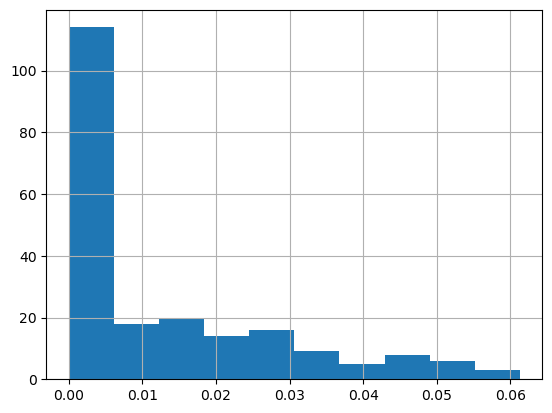

In [107]:
df[df.genTipoComp == 'MF'].genPondAvance.hist()

In [108]:
refOS = 505900880700
print(f'{refOS}: {df[df.index == refOS].genPondAvance.iloc[0]}')

refOS = 505900899400
print(f'{refOS}: {df[df.index == refOS].genPondAvance.iloc[0]}')

505900880700: 0.02156795617939062
505900899400: 0.014967925873129008


### Cursos All

In [109]:
fHistorial

,NPersonal,estadoFinalizado,calificacion,puntaje,IDCurso
0,3479164,0,NaN,0.0,FINSA-FLL-027
1,3488758,1,No apto,10.0,ADN02
2,3485764,0,NaN,0.0,ADN02
3,3481247,1,Apto,89.0,CME2270
4,3479009,1,Apto,100.0,CME2270
...,...,...,...,...,...
1454,3479445,1,Apto,85.0,HME0543
1455,3484096,1,Apto,90.0,HME0543
1456,3484033,1,Apto,82.0,HME0543
1457,3479002,1,Apto,95.0,HME0543


In [148]:
# Copia al historico de cursos
fCompletadosAll = fHistorial.copy()
fCompletadosAll['IDCurso'] = fCompletadosAll['IDCurso'].astype(str)
fCompletadosAll = fCompletadosAll[(fCompletadosAll.calificacion == 'Apto')]

# Escoger cursos que estan tanto en el historial como en el listado de cursos
s1 = hCursosAll.IDCurso.str.strip()
s2 = fHistorial.IDCurso.str.strip()
cursosInHistorial = list(set(s1).intersection(set(s2)))
fCompletadosAll = fCompletadosAll[fCompletadosAll.IDCurso.isin(cursosInHistorial)]

fCompletadosAll = fCompletadosAll.groupby(['NPersonal','IDCurso']).size().reset_index()

# Contar Cursos Completados
fCursosCompletadosAll = fCompletadosAll.NPersonal.value_counts().reset_index()
fCursosCompletadosAll.columns = ['NPersonal','completados']
fCursosCompletadosAll.set_index('NPersonal',inplace=True)
fCursosCompletadosAll['Nivel'] = fTrabajadores.Nivel

# Agregando cursos por nivel
cursosPorNivel = hCursosAll.Nivel.value_counts().to_dict()
fCursosCompletadosAll['TotalCursos'] = fCursosCompletadosAll.Nivel.map(cursosPorNivel)

fCursosCompletadosAll['avance'] = fCursosCompletadosAll.completados / fCursosCompletadosAll['TotalCursos']

In [149]:

# Contar Cursos Completados
fCursosCompletadosAll = fCompletadosAll.NPersonal.value_counts().reset_index()
fCursosCompletadosAll.columns = ['NPersonal','completados']
fCursosCompletadosAll.set_index('NPersonal',inplace=True)

fCursosCompletadosAll['Nivel'] = fTrabajadores.Nivel

fCursosCompletadosAll = fCursosCompletadosAll[~fCursosCompletadosAll.Nivel.isna()]
# Agregando cursos por nivel
cursosPorNivel = hCursosAll.Nivel.value_counts().to_dict()
fCursosCompletadosAll['TotalCursos'] = fCursosCompletadosAll.Nivel.map(cursosPorNivel)

fCursosCompletadosAll['avance'] = fCursosCompletadosAll.completados / fCursosCompletadosAll['TotalCursos']

fCursosCompletadosAll.head()

,completados,Nivel,TotalCursos,avance
NPersonal,,,,
3484587,26,M2,24,1.083333
3479002,25,M3,30,0.833333
3479131,25,T1,19,1.315789
3481247,20,M3,30,0.666667
3484033,20,M2,24,0.833333


In [155]:
hhCurso = fHh.copy()

# Filtro de Operaciones para obtener solo aquellas que se relacionan con desarme y evaluación
# filterDesarme = tempDesarme.Orden.astype(str) + tempDesarme.Operacion.astype(str)

# operInDesarme = (hhCurso.Orden.astype(str) + hhCurso.Operacion.astype(str))

# hhCurso = hhCurso[operInDesarme.isin(filterDesarme)]

# obtener total de trabajo realizado por un operario
hhCurso = hhCurso.groupby(['OSMadre','NPersonal'])['TrabajoReal'].sum().reset_index()
hhCurso.set_index(['NPersonal'],inplace=True)

hhCurso['avance'] = fCursosCompletadosAll.avance
hhCurso.reset_index(inplace=True)
hhCurso['avance'] = pd.to_numeric(hhCurso['avance'], errors='coerce')

# calcular porcentajes relativos
hhCurso['porcTrab'] =(hhCurso['TrabajoReal'] / hhCurso.groupby('OSMadre')['TrabajoReal'].transform('sum'))
# calcular ponderador
hhCurso['pondAvance'] = hhCurso['porcTrab'] * hhCurso['avance']

pondAvanceAll = hhCurso.groupby(['OSMadre'])['pondAvance'].sum().reset_index()

pondAvanceAll = hhCurso.groupby(['OSMadre'])['pondAvance'].sum().reset_index()

pondAvanceAll.set_index('OSMadre', inplace=True)

df['genPndCursos'] = pondAvanceAll.pondAvance

# Variables de Costos

In [127]:
costosOs = fWip.groupby(['OSMadre'])['costoRepuesto','costoMO','costoTTA','costoTotal'].sum()
df[['repYCostos','moYCostos','ttaYCostos','genYCostos']] = costosOs


c:\Users\giaan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [128]:
print(df.isna().sum()[df.isna().sum()!=0])

genDuracion                  1
genDemora                    2
repNP                        8
repNPNuevo                   9
repNPExterno               860
repNPMS                    897
repKitNP                    18
repKitNPNuevo               18
repKitNPExterno            945
repNoKitNP                  10
repNoKitNPNuevo             11
repNoKitNPExterno          886
repCant                      8
repCantNuevo                 9
repCantExterno             860
repCantMS                  897
repKitCant                  18
repKitCantNuevo             18
repKitCantExterno          945
repNoKitCant                10
repNoKitCantNuevo           11
repNoKitCantExterno        886
moTrabajoReal                4
moVariacion                  4
moDesarmeTrabajoReal         6
moDesarmeVariacion           6
moSalvatajeTrabajoReal      28
moSalvatajeVariacion        28
moArmadoTrabajoReal          6
moArmadoVariacion            6
moTrabPersonal               4
moCantPersonal               4
moDesarm

# Tratando Datos Faltantes y outliers

In [129]:
len(df)

1091

### Tratando NaN

In [130]:
# Remover filas que no tienen los costos generales
filterNan = df.copy()
filterNan = filterNan[~filterNan.genYCostos.isna()]
# print(filterNan.isna().sum()[filterNan.isna().sum()!=0])
# Remover columnas con muchos NaN
# Si mas del 50% de los datos son NaN, se elimina la columna
tolerancia = 0.5
filterNan = filterNan[filterNan.columns[filterNan.isna().mean() < tolerancia]]
# filterNan = filterNan.dropna(axis=1, thresh=len(df)-tolerancia)
print(filterNan.isna().sum()[filterNan.isna().sum()!=0])
# Dado que las columnas que tienen NaN, son cantidades, se transformam a cero
filterNan.fillna(0,inplace=True)

genDuracion                 1
repKitNP                    9
repKitNPNuevo               9
repNoKitNP                  2
repNoKitNPNuevo             2
repKitCant                  9
repKitCantNuevo             9
repNoKitCant                2
repNoKitCantNuevo           2
moSalvatajeTrabajoReal     21
moSalvatajeVariacion       21
moSalvatajeTrabPersonal    21
moSalvatajeCantPersonal    21
genPondNivel                5
genPondAvance               5
dtype: int64


### Tratando valores con 0

In [131]:
# Remover columnas con muchos 0
# Si mas del 80% de los datos son 0, se elimina la columna
tolerancia = 0.8
filtrador = (filterNan == 0).astype(int)
filterZeros = filterNan[filterNan.columns[filtrador.mean() < tolerancia]]
printer = (filterZeros == 0).astype(int)
print(printer.sum()[printer.sum()!=0])

genHh                       19
genNVueltas                377
genDuracion                  1
genDemora                  304
repKitNP                     9
repKitNPNuevo                9
repNoKitNP                   2
repNoKitNPNuevo              2
repKitCant                   9
repKitCantNuevo              9
repNoKitCant                 2
repNoKitCantNuevo            2
moVariacion                  2
moDesarmeVariacion          79
moSalvatajeTrabajoReal      21
moArmadoVariacion            4
moDesarmeTrabPersonal        5
moDesarmeCantPersonal        5
moSalvatajeTrabPersonal    109
moSalvatajeCantPersonal    109
moArmadoTrabPersonal         1
moArmadoCantPersonal         1
genPondNivel                 7
genPondAvance              663
genPndCursos                50
ttaYCostos                 462
dtype: int64


In [132]:
listaColMedia = ['genDuracion','genPondExp']
cleanDf = replaceConditionalMean(filterZeros,['genTipoComp'],listaColMedia)
cleanDf[listaColMedia].isna().sum()

genDuracion    0
genPondExp     0
dtype: int64

In [133]:
printer = (cleanDf == 0).astype(int)
print(printer.sum()[printer.sum()!=0])

genHh                       19
genNVueltas                377
genDuracion                  1
genDemora                  304
repKitNP                     9
repKitNPNuevo                9
repNoKitNP                   2
repNoKitNPNuevo              2
repKitCant                   9
repKitCantNuevo              9
repNoKitCant                 2
repNoKitCantNuevo            2
moVariacion                  2
moDesarmeVariacion          79
moSalvatajeTrabajoReal      21
moArmadoVariacion            4
moDesarmeTrabPersonal        5
moDesarmeCantPersonal        5
moSalvatajeTrabPersonal    109
moSalvatajeCantPersonal    109
moArmadoTrabPersonal         1
moArmadoCantPersonal         1
genPondNivel                 7
genPondAvance              663
genPndCursos                50
ttaYCostos                 462
dtype: int64


## Removiendo columnas cualitativamente no significantes (Diagrama Causa Efecto)

In [134]:
ceDf = cleanDf.copy()
ceDf.drop(columns=['genDuracion'], inplace=True)

## Tratando columnas correlacionadas

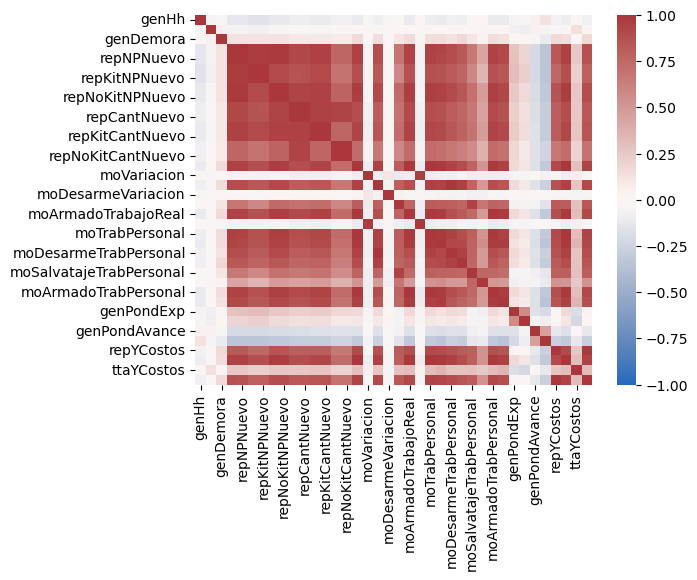

In [135]:
matrix = ceDf.corr(method = 'pearson', min_periods = 1).round(2)
sns.heatmap(matrix,vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

In [136]:
filterDf = ceDf.copy()
# Dropping corrrelated columns
# Relacionado con repuestos
filterDf.drop(columns=['repNPNuevo','repKitNP','repKitNPNuevo','repNoKitNP','repNoKitNPNuevo','repCant','repCantNuevo','repKitCant','repKitCantNuevo'],inplace=True)

# Relacionado con repuestos
filterDf.drop(columns=['moCantPersonal','moDesarmeTrabPersonal','moDesarmeCantPersonal','moDesarmeTrabajoReal','moSalvatajeTrabPersonal','moTrabajoReal'],inplace=True)

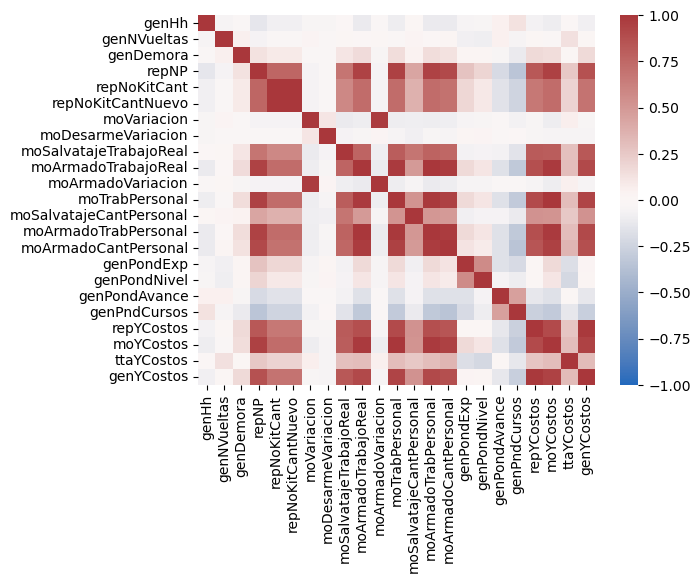

In [137]:
matrix = filterDf.corr(method = 'pearson', min_periods = 1).round(2)
sns.heatmap(matrix,vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

In [138]:
# Segunda iteracion
filterDf2 = filterDf.copy()
# Dropping corrrelated columns
# Relacionado con repuestos
filterDf2.drop(columns=['repNoKitCantNuevo'],inplace=True)

# Relacionado con mano de obra
filterDf2.drop(columns=['moArmadoTrabPersonal','moArmadoCantPersonal','moArmadoTrabajoReal','moArmadoVariacion','moTrabPersonal'],inplace=True)

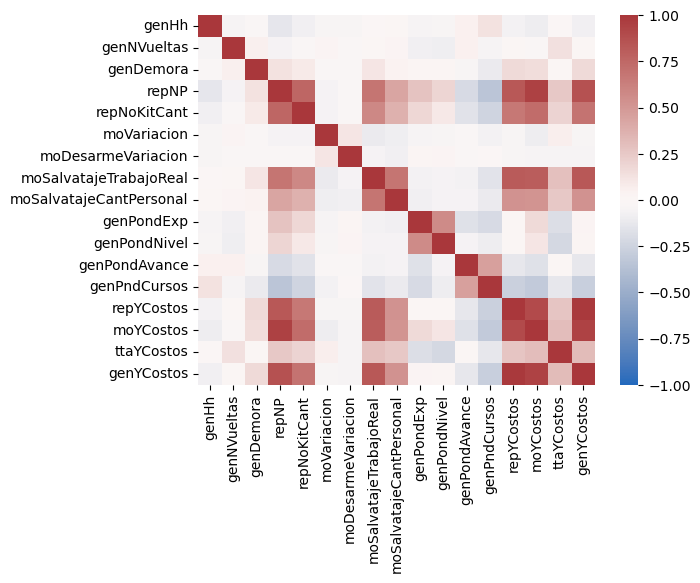

In [139]:
matrix = filterDf2.corr(method = 'pearson', min_periods = 1).round(2)
sns.heatmap(matrix,vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

In [140]:
filterDf2

,genTipoComp,genModelo,genEstado,genTipoReparacion,genHh,genNVueltas,genDemora,repNP,repNoKitCant,moVariacion,...,moSalvatajeTrabajoReal,moSalvatajeCantPersonal,genPondExp,genPondNivel,genPondAvance,genPndCursos,repYCostos,moYCostos,ttaYCostos,genYCostos
OSMadre,,,,,,,,,,,,,,,,,,,,,
505900078900,MO,797F,DESPACHO,Overhaul,11537.0,3,-4.0,748.0,2443.0,0.106629,...,44.5,7.0,2433.726300,2.864615,0.000000,0.009427,353396.34,44808.31,165.93,409120.58
505900080900,MO,Otros modelos de MO,DESPACHO,Overhaul,25167.0,0,0.0,664.0,1583.0,0.118208,...,33.0,4.0,2703.899688,2.987234,0.000000,0.015427,253138.82,32281.09,1364.02,299914.32
505900088700,MO,797B,DESPACHO,Overhaul,12295.0,2,0.0,1157.0,6846.0,0.217008,...,0.0,0.0,3819.534904,3.232964,0.000000,0.008796,412310.59,66509.03,2093.40,511163.02
505900111400,MO,793C,DESPACHO,Overhaul,4364.0,2,0.0,624.0,1412.0,0.227270,...,0.0,0.0,3411.412077,3.543860,0.000000,0.021437,189422.26,32109.42,1198.09,237829.77
505900127200,MO,Otros modelos de MO,DESPACHO,Overhaul,0.0,0,0.0,807.0,2113.0,0.207955,...,38.5,3.0,4313.928000,3.800000,0.000000,0.032094,248316.76,29690.69,1416.82,290786.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505901343300,MA,797B,DESPACHO,Proceso Continuo,14547.0,4,0.0,25.0,21.0,0.064000,...,13.0,3.0,2024.990000,3.036145,0.028287,0.083207,76560.07,5858.98,0.00,82419.05
505901346600,MA,797F,DESPACHO,Proceso Continuo,21256.0,2,0.0,35.0,24.0,0.074403,...,11.5,2.0,2243.938567,1.000000,0.000000,0.157143,64758.38,5722.27,0.00,70609.53
505901349800,MF,797F,DESPACHO,Proceso Continuo,23099.0,3,0.0,17.0,18.0,0.991479,...,16.0,1.0,3592.122807,2.761905,0.000000,0.174356,82203.88,7792.44,0.00,97211.58


In [141]:
len(filterDf2)

995

In [142]:
print('COMPLETO')
for i in ['CO','DI','MA','MF','MO','TR']:
    media = filterDf2[filterDf2['genTipoComp']==i].genYCostos.mean()
    print(i+": " + str(round(media,2)))
print("Completo: " + str(round(filterDf2.genYCostos.mean(),2)))
print('MANO DE OBRA')
for i in ['CO','DI','MA','MF','MO','TR']:
    media = filterDf2[filterDf2['genTipoComp']==i].moYCostos.mean()
    print(i+": " + str(round(media,2)))
print("Completo: " + str(round(filterDf2.moYCostos.mean(),2)))
for i in ['CO','DI','MA','MF','MO','TR']:
    media = filterDf2[filterDf2['genTipoComp']==i].repYCostos.mean()
    print(i+": " + str(round(media,2)))
print("Completo: " + str(round(filterDf2.repYCostos.mean(),2)))
print('REPUESTOS')

COMPLETO
CO: 35037.6
DI: 33721.3
MA: 87831.09
MF: 109250.58
MO: 369889.85
TR: 56408.85
Completo: 99712.96
MANO DE OBRA
CO: 5619.03
DI: 3979.83
MA: 6832.59
MF: 7552.11
MO: 49916.19
TR: 7299.8
Completo: 10697.38
CO: 28795.99
DI: 27964.77
MA: 72740.66
MF: 99503.52
MO: 296196.11
TR: 46038.13
Completo: 83288.43
REPUESTOS


# Exportar Datos

In [143]:
ruta_destino = '04_Modelamiento/Datos'
exportDf = filterDf2.copy()

# Opcional filtrar modelos que no son significativos
exportDf = exportDf[~exportDf['genModelo'].str.startswith('Otros modelos')]
# De SAP
exportar_csv(exportDf,ruta_destino,'datosPreprocesados')
exportar_excel(exportDf,ruta_destino,'datosPreprocesados')
exportar_excel(matrix,ruta_destino,'corrMatrix', True)

In [144]:
exportDf


,genTipoComp,genModelo,genEstado,genTipoReparacion,genHh,genNVueltas,genDemora,repNP,repNoKitCant,moVariacion,...,moSalvatajeTrabajoReal,moSalvatajeCantPersonal,genPondExp,genPondNivel,genPondAvance,genPndCursos,repYCostos,moYCostos,ttaYCostos,genYCostos
OSMadre,,,,,,,,,,,,,,,,,,,,,
505900078900,MO,797F,DESPACHO,Overhaul,11537.0,3,-4.0,748.0,2443.0,0.106629,...,44.5,7.0,2433.726300,2.864615,0.000000,0.009427,353396.34,44808.31,165.93,409120.58
505900088700,MO,797B,DESPACHO,Overhaul,12295.0,2,0.0,1157.0,6846.0,0.217008,...,0.0,0.0,3819.534904,3.232964,0.000000,0.008796,412310.59,66509.03,2093.40,511163.02
505900111400,MO,793C,DESPACHO,Overhaul,4364.0,2,0.0,624.0,1412.0,0.227270,...,0.0,0.0,3411.412077,3.543860,0.000000,0.021437,189422.26,32109.42,1198.09,237829.77
505900158900,MO,797B,DESPACHO,Overhaul,14628.0,1,0.0,1136.0,5451.0,0.182184,...,33.5,4.0,4163.242563,2.482821,0.000000,0.008890,367988.14,72564.75,11220.23,484908.72
505900175200,MO,797F,DESPACHO,Overhaul,2931.0,2,343.0,702.0,2345.0,-0.019327,...,27.5,3.0,3582.214459,3.116031,0.000000,0.017442,388779.30,50695.76,222.50,449449.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505901343300,MA,797B,DESPACHO,Proceso Continuo,14547.0,4,0.0,25.0,21.0,0.064000,...,13.0,3.0,2024.990000,3.036145,0.028287,0.083207,76560.07,5858.98,0.00,82419.05
505901346600,MA,797F,DESPACHO,Proceso Continuo,21256.0,2,0.0,35.0,24.0,0.074403,...,11.5,2.0,2243.938567,1.000000,0.000000,0.157143,64758.38,5722.27,0.00,70609.53
505901349800,MF,797F,DESPACHO,Proceso Continuo,23099.0,3,0.0,17.0,18.0,0.991479,...,16.0,1.0,3592.122807,2.761905,0.000000,0.174356,82203.88,7792.44,0.00,97211.58


In [145]:
exportDf['genModelo' ].str.startswith('Otros modelos').value_counts()

False    876
Name: genModelo, dtype: int64